In [1]:
import pandas as pd
import numpy as np

seeds = [f's{i}' for i in range(1, 11)]
experiments = ['standard', 'p0']
tests = {}
stats = {}

base_dir = '../../datalake/wcci'

for experiment in experiments:
    experiment_dir = f'{base_dir}/{experiment}/data/xdpole/runstats'
    tests[experiment] = []
    stats[experiment] = {}
    for seed in seeds:
        seed_test = pd.read_csv(f'{experiment_dir}/{seed}_test.csv')
        tests[experiment].append(seed_test.score[0])

        seed_stats = pd.read_csv(f'{experiment_dir}/{seed}_run.csv')
        stats[experiment][seed] = seed_stats

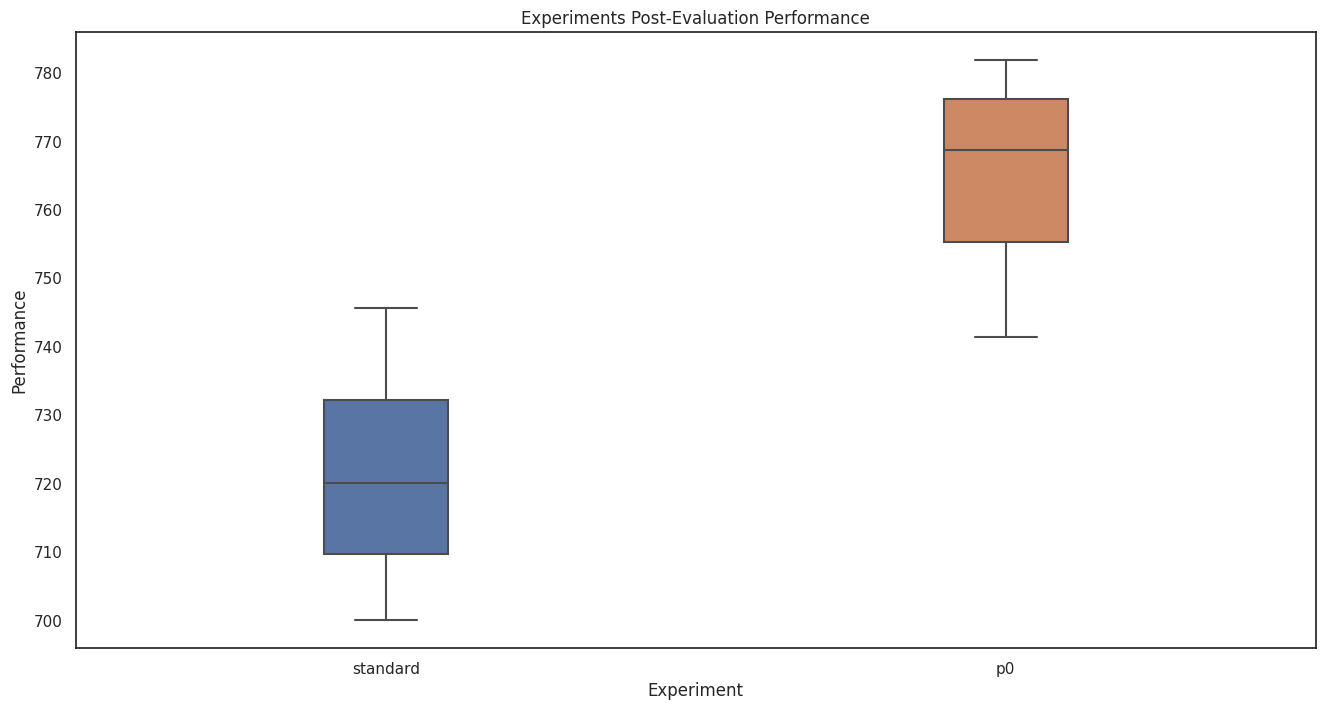

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set(rc={'figure.figsize':(16,8)}, style='white')


df = pd.DataFrame(tests)
sns.boxplot(df, flierprops={"marker": "x"}, width=0.2)
plt.title("Experiments Post-Evaluation Performance")
plt.ylabel("Performance")
plt.xlabel("Experiment")
plt.show()

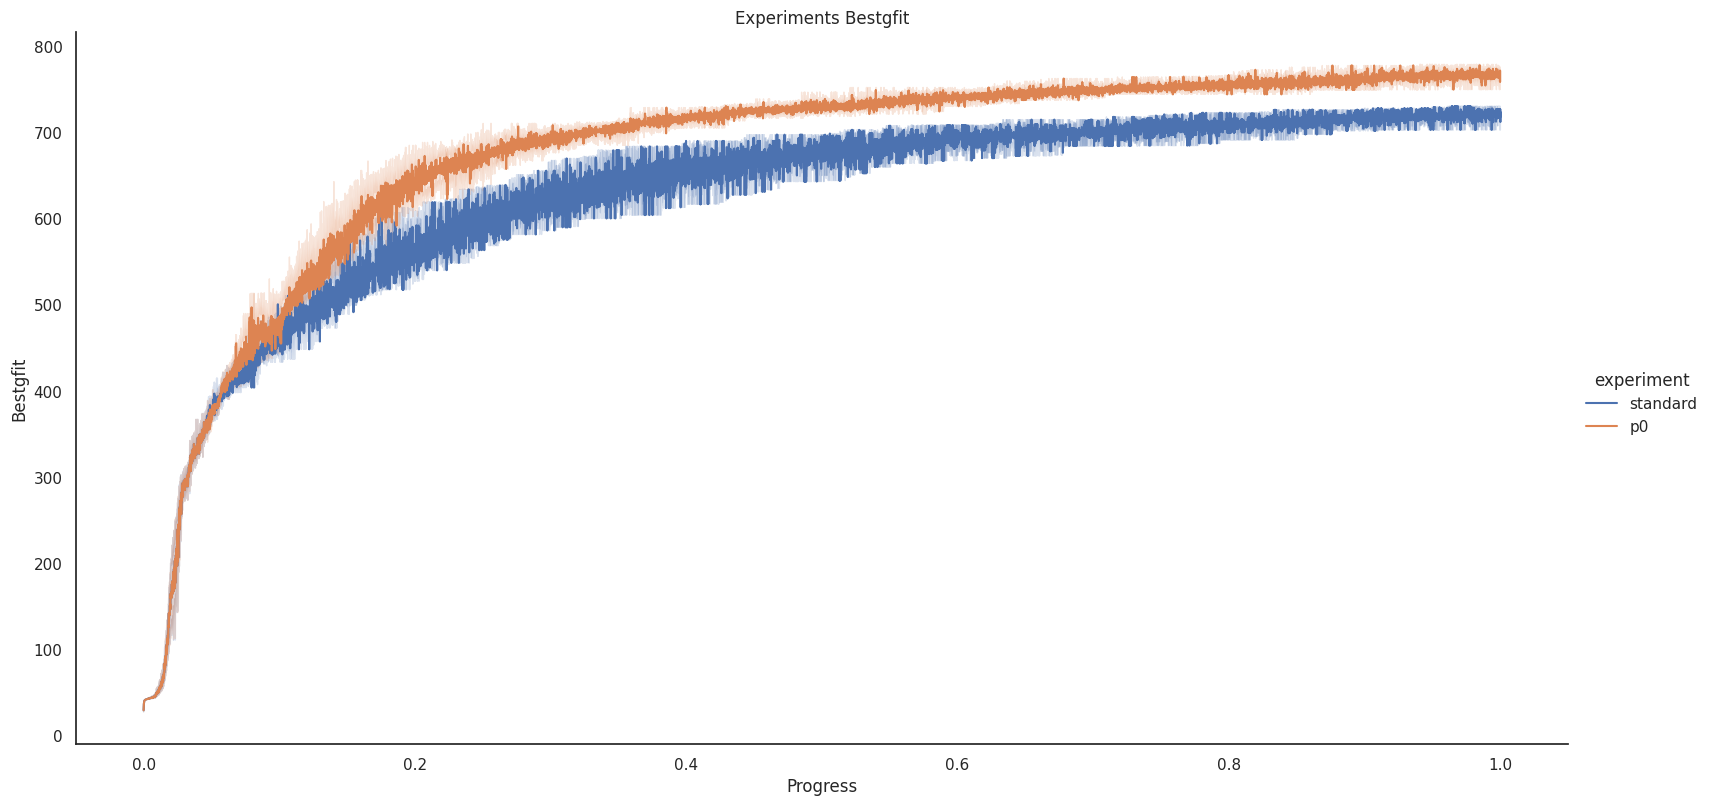

In [3]:
mean_stats = pd.DataFrame()

maxmsteps = 10000

for experiment in experiments:
    experiment_stats = stats[experiment]

    seeds_df = pd.DataFrame()
    for seed in seeds:
        seed_df = experiment_stats[seed]
        seed_df['seed'] = seed
        seed_df['progress'] = [i/maxmsteps for i in seed_df.msteps]
        seed_df['performance'] = seed_df.bestgfit.rolling(100).mean()

        seeds_df = pd.concat([seeds_df, seed_df], ignore_index=True) if not seeds_df.empty else seed_df

    seeds_df['experiment'] = experiment
    mean_stats = pd.concat([mean_stats, seeds_df], ignore_index=True) if not mean_stats.empty else seeds_df

sns.relplot(mean_stats, x='progress', y='bestgfit', hue='experiment', kind='line', height=8, aspect=2)
plt.title("Experiments Bestgfit")
plt.ylabel("Bestgfit")
plt.xlabel("Progress")
plt.show()